# Introduction to Computer Vision: Twitter US Airline Sentiment

## Problem Statement

### Context

Twitter's massive user base of 330 million monthly active users presents a direct avenue for businesses to connect with a broad audience. However, the vast amount of information on the platform makes it challenging for brands to swiftly detect negative social mentions that may impact their reputation. To tackle this, sentiment analysis has become a crucial tool in social media marketing, enabling businesses to monitor emotions in conversations, understand customer sentiments, and gain insights to stay ahead in their industry.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

### Objective

The aim of this project is to build a sentimental analysis model that classify the sentiment of tweets into the positive, neutral & negative.

### Data Dictionary

* tweet_id - A unique identifier for each tweet                                                          
* airline_sentiment - The sentiment label of the tweet, such as positive, negative, or neutral                                               
* airline_sentiment_confidence - The confidence level associated with the sentiment label                               
* negativereason - A category indicating the reason for negative sentiment                                                   
* negativereason_confidence - The confidence level associated with the negative reason                                    
*airline - The airline associated with the tweet                                                                   
* airline_sentiment_gold - Gold standard sentiment label                                               
* name - The username of the tweet author    
* retweet_count - The number of times the tweet has been retweeted
* text - The actual text content of the tweet.
* tweet_coord - Coordinates of the tweet
* tweet_created - The timestamp when the tweet was created
* tweet_location - The location mentioned in the tweet
* user_timezone - The timezone of the tweet author

## Importing necessary libraries

In [1]:
# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.
import seaborn as sns                                   # Import seaborn
import matplotlib.pyplot as plt                         # Import Matplotlib

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from wordcloud import WordCloud,STOPWORDS               # Import WorldCloud and Stopwords
from sklearn.feature_extraction.text import CountVectorizer # Import count Vectorizer
from sklearn.model_selection import train_test_split    # Import train test split
from sklearn.ensemble import RandomForestClassifier     # Import Rndom Forest Classifier
from sklearn.model_selection import cross_val_score     # Import cross val score
from sklearn.metrics import confusion_matrix            # Import confusion matrix
from wordcloud import WordCloud                         # Import Word Cloud
from sklearn.feature_extraction.text import TfidfVectorizer # Import Tf-Idf vector
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Loading the dataset

In [2]:
# Mount Google drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv("/content/drive/My Drive/NLP/project/Tweets.csv")               # Read the dataset

## Data Overview

### Check the head and tail of the data

In [4]:
data.head(5)                            # Display the first 5 rows of the dataset
data.tail(5)                            # Ddisplay the last 5 rows of the dataset

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)
14639,569587140490866689,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2015-02-22 11:58:51 -0800,"dallas, TX",NaN


### Understand the shape of the dataset

In [5]:
data.shape                           # Shape of data

(14640, 15)

### Checking for Missing Values

In [6]:
data.isnull().sum()                             # Check duplicate entries in the data

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

## Exploratory Data Analysis

### Univariate Analysis

In [7]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

#### Percentage of tweets for each airline



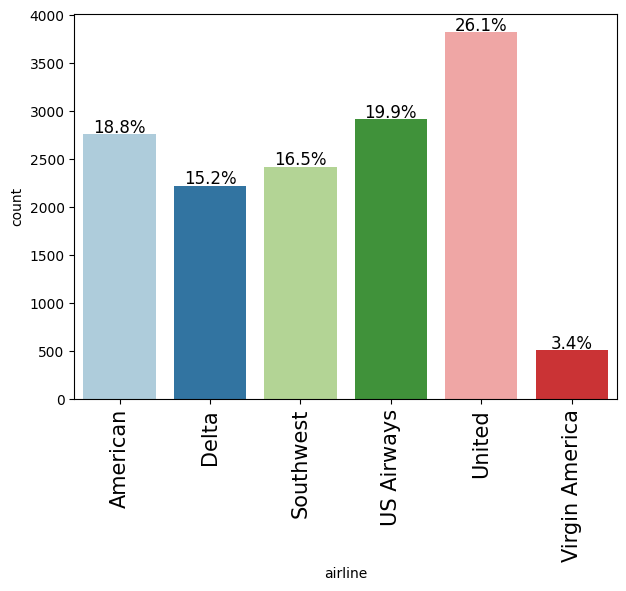

In [8]:
labeled_barplot(data, "airline", perc=True)         # Plot the labeled barplot for airline

#### Distribution of sentiments across all the tweets

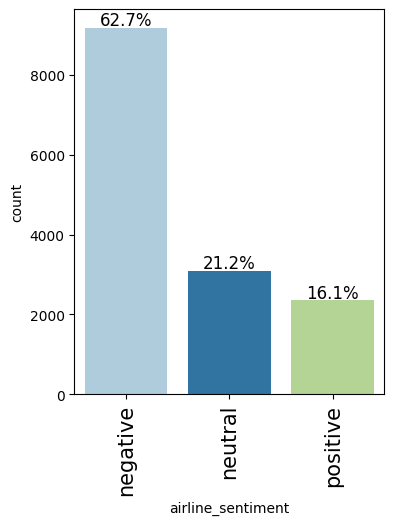

In [9]:
labeled_barplot(data, "airline_sentiment", perc=True) # Plot the labeled barplot for airline_sentiment

#### Plot of all the negative reasons

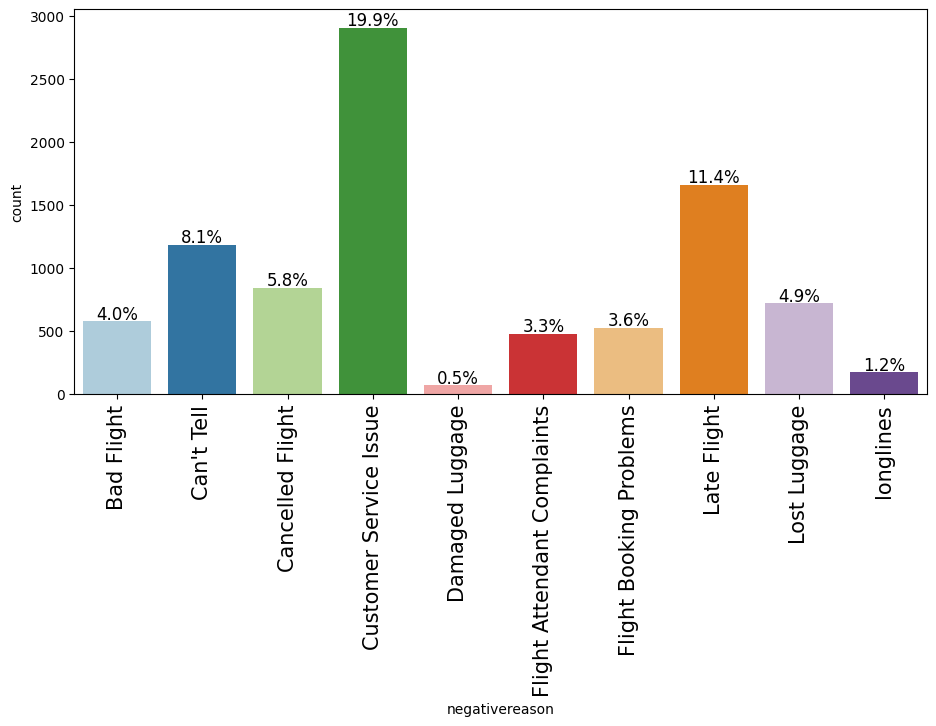

In [10]:
labeled_barplot(data, "negativereason", perc=True)             # Plot the labeled barplot for negative reason

### Bivariate Analysis

#### Distribution of Sentiment of tweets for each airline

<Axes: xlabel='airline'>

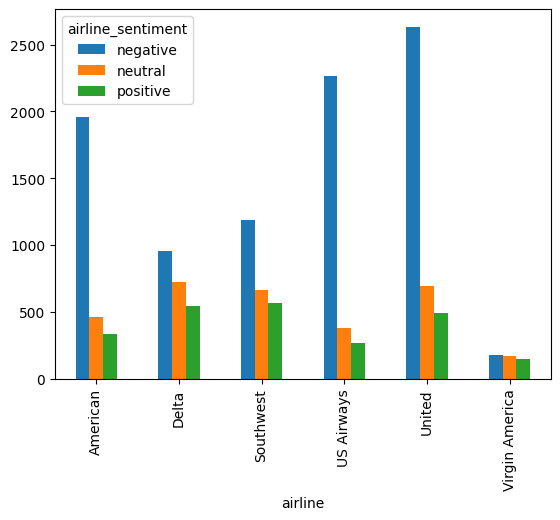

In [11]:
airline_sentiment =  data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()    # Plot the barplot for the distribution of each airline with total sentiments
airline_sentiment.plot(kind='bar')

#### Wordcloud for negative tweets

In [12]:
airline_tweets=data[data['airline_sentiment']=='negative']
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

In [13]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

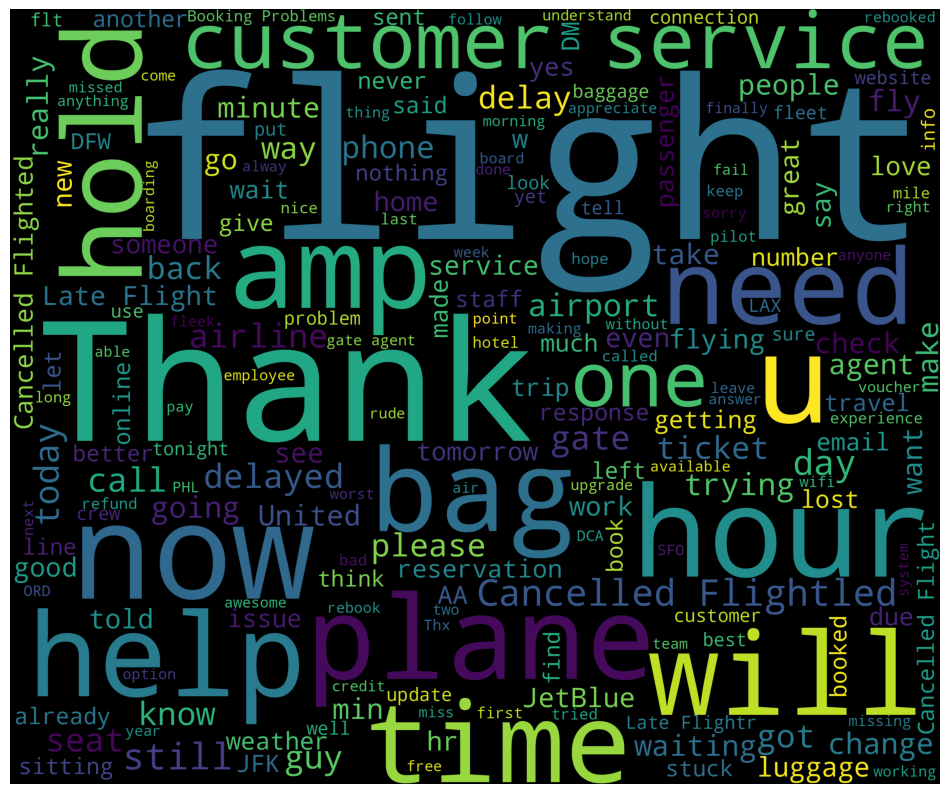

In [14]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Wordcloud for positive tweets

In [15]:
airline_tweets_pos=data[data['airline_sentiment']=='positive']
words = ' '.join(data['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'])

In [16]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

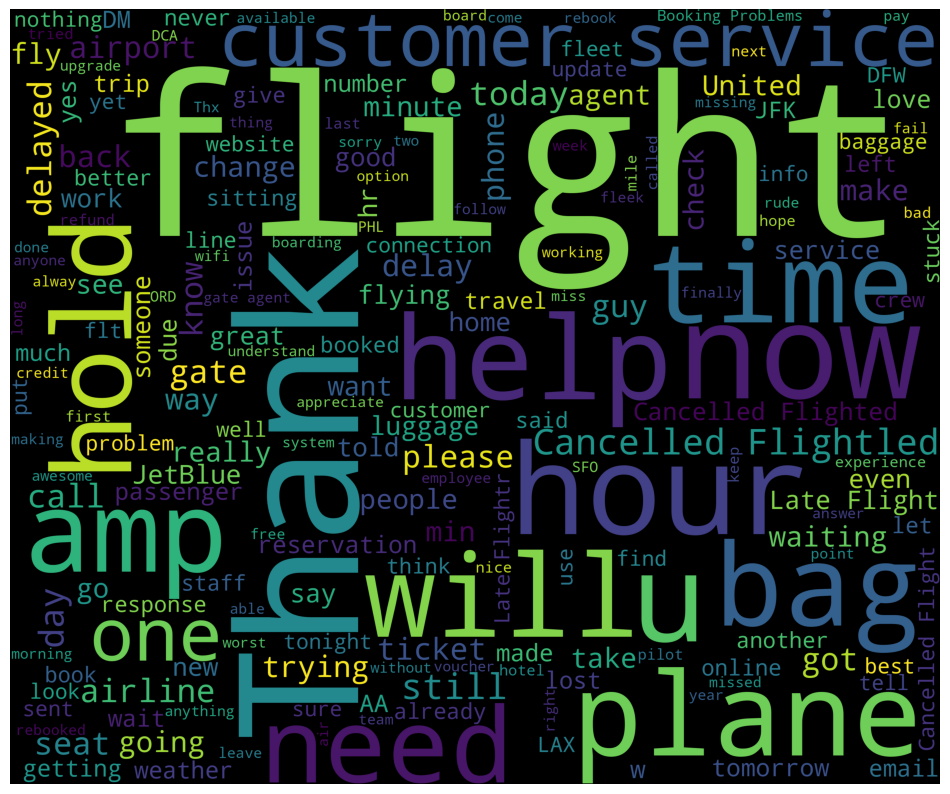

In [17]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Data Preparation for Modeling



- Drop all unnecessary columns
- Remove html tags
- Replace contractions in string(e.g. replace I'm --> I am) and so on.\
- Remove numbers
- Tokenization
- To remove Stopwords
- Lemmatized data

### Drop all unnecessary columns

In [18]:
# Take text and airline sentiment columns from the data
data = data[['text', 'airline_sentiment']]                      # Get a subset of data

In [19]:
data.head(5)                                                    # display the first 5 rows of the dataset

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [20]:
data.shape                                                           # Shape of the data

(14640, 2)

In [21]:
data['airline_sentiment'].value_counts()                                         # Display the unique values in airline sentiment column

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [22]:
data['airline_sentiment'].tolist()                                         # Display the values in airline sentiment column

['neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'ne

In [23]:
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


### Remove HTML Tages

In [24]:
# Code to remove the html tage
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(strip_html)                        # Apply strip html function on text column
data.head(10)                                                        # Display the head of the data

<ipython-input-24-3dfcf9ca5b7c>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an ...",positive


### Replace contractions in string

In [25]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

data['texty'] = data['text'].apply(lambda x: replace_contractions(x))                  # Apply replace contractions function on text column
data.head(10)                                                                          # display the head of the data

,text,airline_sentiment,texty
0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you have added commercials...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I did not today... Must mean I ...
3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it is really aggressive to blas...
4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it is a really big bad thin...
5,@VirginAmerica seriously would pay $30 a fligh...,negative,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,@VirginAmerica Really missed a prime opportuni...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"@VirginAmerica it was amazing, and arrived an ..."


### Remove numbers

In [26]:
def remove_numbers(text):
  text = re.sub(r'[0-9]', '', text)
  return text

data['text'] = data['text'].apply(remove_numbers)                  # Apply remove numbers function on text column
data.head(10)                                                      # Display the head of the data

,text,airline_sentiment,texty
0,@VirginAmerica What @dhepburn said.,neutral,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...,positive,@VirginAmerica plus you have added commercials...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,@VirginAmerica I did not today... Must mean I ...
3,@VirginAmerica it's really aggressive to blast...,negative,@VirginAmerica it is really aggressive to blas...
4,@VirginAmerica and it's a really big bad thing...,negative,@VirginAmerica and it is a really big bad thin...
5,@VirginAmerica seriously would pay $ a flight ...,negative,@VirginAmerica seriously would pay $30 a fligh...
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,@VirginAmerica Really missed a prime opportuni...,neutral,@VirginAmerica Really missed a prime opportuni...
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,"@VirginAmerica it was amazing, and arrived an ...",positive,"@VirginAmerica it was amazing, and arrived an ..."


### Apply Tokenization

In [27]:
data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

0           [@, VirginAmerica, What, @, dhepburn, said, .]
1        [@, VirginAmerica, plus, you, 've, added, comm...
2        [@, VirginAmerica, I, did, n't, today, ..., Mu...
3        [@, VirginAmerica, it, 's, really, aggressive,...
4        [@, VirginAmerica, and, it, 's, a, really, big...
                               ...                        
14635    [@, AmericanAir, thank, you, we, got, on, a, d...
14636    [@, AmericanAir, leaving, over, minutes, Late,...
14637    [@, AmericanAir, Please, bring, American, Airl...
14638    [@, AmericanAir, you, have, my, money, ,, you,...
14639    [@, AmericanAir, we, have, ppl, so, we, need, ...
Length: 14640, dtype: object

In [28]:
# Apply tokenization on text column
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
# Display the head of the data
data.head(10)

,text,airline_sentiment,texty
0,"[@, VirginAmerica, What, @, dhepburn, said, .]",neutral,@VirginAmerica What @dhepburn said.
1,"[@, VirginAmerica, plus, you, 've, added, comm...",positive,@VirginAmerica plus you have added commercials...
2,"[@, VirginAmerica, I, did, n't, today, ..., Mu...",neutral,@VirginAmerica I did not today... Must mean I ...
3,"[@, VirginAmerica, it, 's, really, aggressive,...",negative,@VirginAmerica it is really aggressive to blas...
4,"[@, VirginAmerica, and, it, 's, a, really, big...",negative,@VirginAmerica and it is a really big bad thin...
5,"[@, VirginAmerica, seriously, would, pay, $, a...",negative,@VirginAmerica seriously would pay $30 a fligh...
6,"[@, VirginAmerica, yes, ,, nearly, every, time...",positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,"[@, VirginAmerica, Really, missed, a, prime, o...",neutral,@VirginAmerica Really missed a prime opportuni...
8,"[@, virginamerica, Well, ,, I, didn't…but, NOW...",positive,"@virginamerica Well, I did not…but NOW I DO! :-D"
9,"[@, VirginAmerica, it, was, amazing, ,, and, a...",positive,"@VirginAmerica it was amazing, and arrived an ..."


### Applying lowercase and removing stopwords and punctuation

**Adding Stopwords**

In [29]:
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

**All the preprocessing steps in one function**

In [30]:
lemmatizer = WordNetLemmatizer()

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)
data.head()

,text,airline_sentiment,texty
0,virginamerica dhepburn say,neutral,@VirginAmerica What @dhepburn said.
1,virginamerica plus add commercials experience ...,positive,@VirginAmerica plus you have added commercials...
2,virginamerica nt today must mean need take ano...,neutral,@VirginAmerica I did not today... Must mean I ...
3,virginamerica really aggressive blast obnoxiou...,negative,@VirginAmerica it is really aggressive to blas...
4,virginamerica really big bad thing,negative,@VirginAmerica and it is a really big bad thin...


## Model Building

### Using countvectorizer

In [31]:
# Vectorization (Convert text data to numbers).

Count_vec = CountVectorizer(max_features=5000)                # Initialize the CountVectorizer function with max_ features = 5000.
data_features = Count_vec.fit_transform(data['text'])         # fit and transrofm the count_vec variable on the text column

# data_features = data_features.to_numpy()                    # Cconvert the datafram into array

In [32]:
data_features
data_features = data_features.toarray()

In [33]:
data_features.shape                                     # Check the shape of the data features

(14640, 5000)

#### Store Independent and Dependent variables

In [34]:
X = data_features                                             # Independent variable (data_features) stored as X

y = data.airline_sentiment                                    # Dependent variable (airline_sentiment) stored as Y

#### Split the data into train and test

In [35]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test =train_test_split (X, y, test_size=0.3, random_state=42)   # split the X and Y into train and test dat

#### Random Forest Model

In [36]:
from sklearn import metrics

In [37]:
## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [38]:
# Using Random Forest to build model for the classification of reviews.

forest = RandomForestClassifier(n_estimators=25, n_jobs=4)    # Initialize the Random Forest Classifier

forest = forest.fit(X_train, y_train)                         # Fit the forest variable on X_train and y_train

print(forest)

print(np.mean(cross_val_score(forest, X, y, cv=10)))          # Calculate cross validation score

RandomForestClassifier(n_estimators=25, n_jobs=4)
0.730191256830601


##### Optimize the parameter: The number of trees in the random forest model(n_estimators)

In [40]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]

In [41]:
# K-Fold Cross - validation .
cv_scores = []                                                                 # Initializing a emptry list to store the score
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)                             # Apply Rondome Forest Classifier
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')          # Find the cross-validation score on the classifier (clf) for accuracy
    cv_scores.append(scores.mean())                                            # Append the scores to cv_scores list

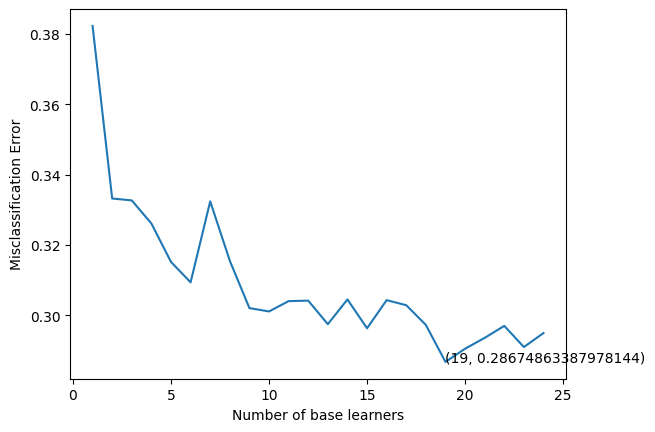

In [42]:
# plot the error as k increases
error = [1 - x for x in cv_scores]                                 # Error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                # Selection of optimal number of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           # Plot between each number of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [43]:
# Train the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = 19)                     # Initialize the Random Forest classifier with optimal learners
clf.fit(X_train, y_train)                                           # Fit the classifer on X_train and y_train
clf.score(X_train, y_train)                                         # Find the score on X_train and y_train

0.9904371584699454

In [44]:
# Predict the result for test data using the model built above.
result = clf.predict(X_test)                                   # Predict the X_test data using the model built above (forest)
print(result)

['positive' 'negative' 'negative' ... 'negative' 'negative' 'negative']


In [45]:
from sklearn.metrics import classification_report

In [46]:

# Plot the confusion matrix
print(classification_report(y_test, result))
conf_mat = confusion_matrix(y_test, result)                      # Calculate the confusion matrix between test data and result
print(conf_mat)                                                  # Print confusion matrix

              precision    recall  f1-score   support

    negative       0.82      0.91      0.86      2814
     neutral       0.59      0.49      0.54       884
    positive       0.76      0.58      0.66       694

    accuracy                           0.77      4392
   macro avg       0.72      0.66      0.69      4392
weighted avg       0.76      0.77      0.76      4392

[[2558  195   61]
 [ 385  436   63]
 [ 186  106  402]]


<Axes: >

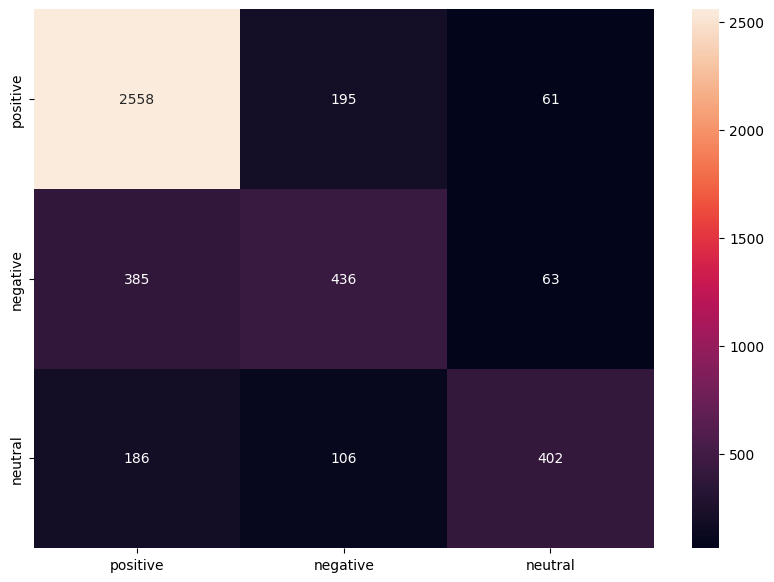

In [47]:
# Plot the confusion matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

#### Wordcloud of top 40 important features from countvectorizer+Randomforest based mode

In [48]:
all_features = Count_vec.get_feature_names_out()                 # Instantiate the feature from the vectorizer
top_features=''                                                  # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','

print(top_features)

print(" ")
print(" ")

# Apply wordcloud on top features
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,height=1000).generate(top_features)

thank,not,nt,jetblue,great,flight,usairways,delay,http,unite,hold,southwestair,hours,awesome,love,get,cancel,americanair,wait,virginamerica,bag,service,amaze,please,dm,hour,still,call,time,best,plane,follow,help,make,say,ca,go,fleek,customer,miss,
 
 


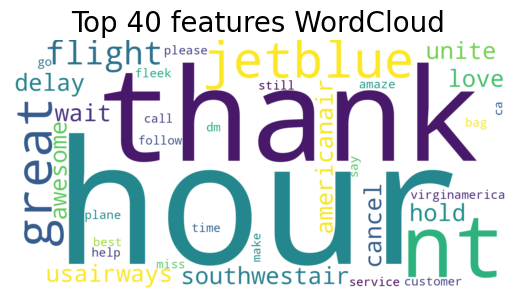

In [49]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

### Using TF-IDF (Term Frequency- Inverse Document Frequency)

In [50]:
# Using TfidfVectorizer to convert text data to numbers.

tfidf_vect = TfidfVectorizer(max_features=5000)                          # Initialize the TF-IDF vector function with max_features = 5000.
data_features = tfidf_vect.fit_transform(data['text'])                   # Fit the tf idf function on the text column

data_features = data_features.toarray()                                  # Complete the code to convert the datafram into array

In [51]:
data_features.shape                                                      # Check the shape of the data features

(14640, 5000)

#### Store Independent and Dependent variables

In [52]:
X = data_features                                                        # Independent variable (data_features) stored as X

y = data.airline_sentiment                                               # Dependent variable (airline_sentiment) stored as Y

#### Split the data into train and test

In [53]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test =train_test_split (X, y, test_size=0.3, random_state=42)   # split the X and Y into train and test dat

#### Random Forest Model

In [54]:
# Using Random Forest to build model for the classification of reviews.

forest = RandomForestClassifier(n_estimators=25, n_jobs=4)              # Initialize the Random Forest Classifier

forest = forest.fit(X_train, y_train)                                   # Fit the forest variable on X_train and y_train

print(forest)

print(np.mean(cross_val_score(forest, X, y, cv=10)))                     # Calculate cross validation score

RandomForestClassifier(n_estimators=25, n_jobs=4)
0.7209699453551912


##### Optimize the parameter: The number of trees in the random forest model(n_estimators)

In [55]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]

In [56]:
# K-Fold Cross - validation .
cv_scores = []                                                                 # Initializing a emptry list to store the score
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)                             # apply Rondome Forest Classifier
    scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')          # Find the cross-validation score on the classifier (clf) for accuracy
    cv_scores.append(scores.mean())                                            # Append the scores to cv_scores list

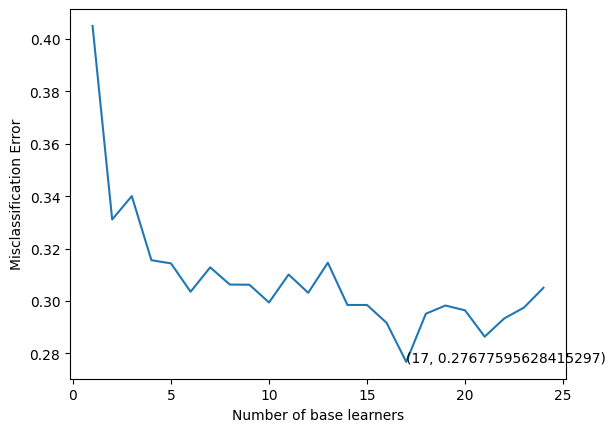

In [57]:
# Plot the misclassification error for each of estimators (Hint: Use the above code which is used while plotting the miscalssification error for CountVector function )
# plot the error as k increases
error = [1 - x for x in cv_scores]                                 # Error corresponds to each number of estimator
optimal_learners = base_ln[error.index(min(error))]                # Selection of optimal number of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           # Plot between each number of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [58]:
# Train the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = 17)                     # Initialize the Random Forest classifier with optimal learners
clf.fit(X_train, y_train)                                          # Fit the classifer on X_train and y_train
clf.score(X_train, y_train)                                        # Find the score on X_train and y_train

0.9890710382513661

In [59]:
# Predict the result for test data using the model built above.
result = clf.predict(X_test)                                   # Predict the X_test data using the model built above (forest)

              precision    recall  f1-score   support

    negative       0.79      0.94      0.86      2814
     neutral       0.62      0.41      0.49       884
    positive       0.79      0.52      0.63       694

    accuracy                           0.77      4392
   macro avg       0.73      0.62      0.66      4392
weighted avg       0.76      0.77      0.75      4392



<Axes: >

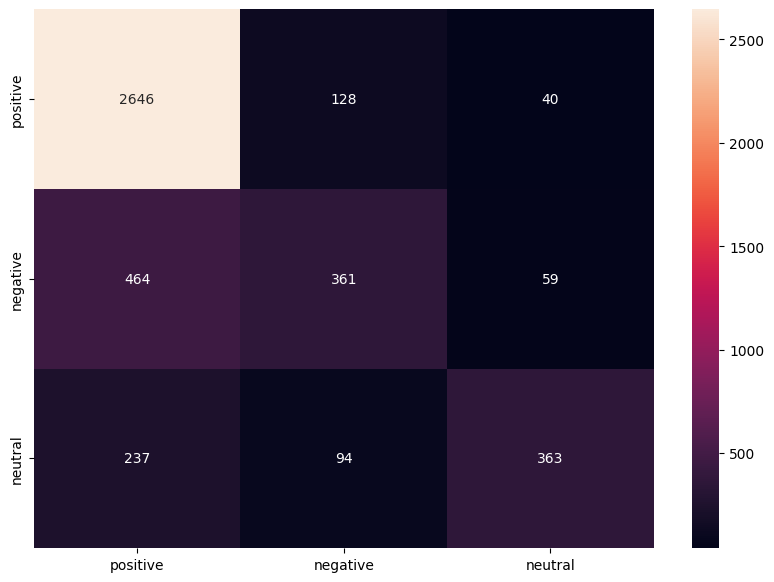

In [60]:
# Plot the confusion matrix
print(classification_report(y_test, result))
conf_mat = confusion_matrix(y_test, result)                      # Calculate the confusion matrix between test data and restust


df_cm = pd.DataFrame(conf_mat, index = [i for i in ['positive', 'negative', 'neutral']],columns = [i for i in ['positive', 'negative', 'neutral']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')                         # Plot the heatmap of the confusion matrix

#### Wordcloud of top 40 important features from TF-IDF+Randomforest based mode

In [61]:
all_features = tfidf_vect.get_feature_names_out()          #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '

print(top_features)

print(" ")
print(" ")

# Apply wordcloud on top features
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000,height=1000).generate(top_features)

thank, jetblue, usairways, southwestair, unite, nt, americanair, flight, great, delay, not, http, virginamerica, love, get, cancel, hold, hours, wait, follow, bag, dm, awesome, call, service, please, fly, customer, fleet, time, amaze, good, still, lose, need, help, make, best, appreciate, would, 
 
 


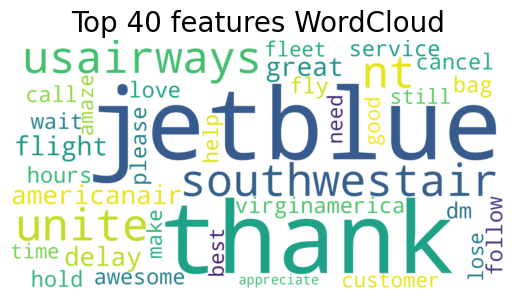

In [62]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

## Summary

---



There are only two important columns - text and airline_sentiment. These columns don’t have any null values. Other columns have many null values but they are not important. So we are not treating them.

Exploratory Data Analysis

26.1% of tweets belong to United Airlines which has highest number and 3.4% of tweets belong to Virgin America which has least no.of tweets.

62.7% or reviews are negative which is highest in number and 16.1% of reviews are positive which are least

Out of all negative reviews, 19.9% belong to Customer Service Issue which is highest and 0.5% belong to Damaged Luggage which is least

9178 of reviews are negative, 3099 reviews are neutral and 2363 are positive reviews.

CountVectorizer
Accuracy on Test data using best RandomForestClassifier is 73%

TFIDF
Accuracy on Test data using best RandomForestClassifier is 77% which works better than CountVectorizer

Looking at the recall scores also TFIDF works better